In [165]:
import pandas as pd
import numpy as np

import tqdm
import matplotlib.pyplot as plt

## Data load

In [166]:
data_path = '../data/'
train = pd.read_csv(data_path + 'train_data.csv')
test = pd.read_csv(data_path + 'test_data.csv')

In [167]:
train['grade'] = 1
test['grade'] = 2

In [168]:
len(train), len(test)

(2266586, 260114)

In [169]:
train['answerCode'].unique(), test['answerCode'].unique()

(array([1, 0], dtype=int64), array([ 1,  0, -1], dtype=int64))

### test에서 answerCode -1인 row 처리
마지막 문제 제외한 sequence까지 학습에 사용하기 위해서

inference에서만 붙여서 쓰기??

In [170]:
remove_index = list(test[test['answerCode']==-1].index)
len(remove_index)

744

In [171]:
test.loc[test[test['answerCode']==-1].index, 'grade'] = 3

In [172]:
# test = test.drop(remove_index)
# len(test), test['answerCode'].unique()

In [173]:
data = pd.concat((train, test), axis=0)
data = data.sort_values('userID')

In [174]:
# total data
data

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1
491,0,A060099007,A060000099,1,2020-09-03 01:08:58,705,1
492,0,A080082001,A080000082,1,2020-09-05 01:08:00,30,1
493,0,A080082002,A080000082,1,2020-09-05 01:09:20,32,1
494,0,A080082003,A080000082,0,2020-09-05 01:09:55,32,1
...,...,...,...,...,...,...,...
2266579,7441,A030071003,A030000071,1,2020-06-05 06:49:23,438,1
2266578,7441,A030071002,A030000071,0,2020-06-05 06:48:43,438,1
2266577,7441,A030071001,A030000071,0,2020-06-05 06:46:41,438,1
2266580,7441,A030071004,A030000071,0,2020-06-05 06:49:57,438,1


In [176]:
# total data 저장
data.sort_values(['userID', 'Timestamp'], inplace=True)
data.to_csv(data_path + 'total_data_test.csv', index=False)

In [177]:
user_id = list(data['userID'].unique())

## User별 Category 각각의 count, acc, elapsetime
Category : 대분류(시험지 카테고리), 중분류(시험지번호), 소분류(문항번호)

In [178]:
data = pd.read_csv(data_path + 'total_data_test.csv', parse_dates=["Timestamp"])

In [179]:
data.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1


In [194]:
data['tag_count'] = data.groupby('userID')['KnowledgeTag'].cumcount()
data['tag_count'].isna().sum()

0

### elapse time
직전 timestamp와의 차이 -> 현재 row에 직전문제의 풀이시간 추가

In [36]:
data = data.sort_values(by=['userID','Timestamp']).reset_index(drop=True)
data

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1
...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1


In [37]:
elapsed = data.loc[:,['userID','Timestamp']].groupby('userID').diff().shift(-1).fillna(method='ffill')#.fillna(pd.Timedelta(seconds=0))

# elapsed = elapsed.fillna(pd.Timedelta(seconds=0))
elapsed = elapsed['Timestamp'].apply(lambda x: x.total_seconds())
elapsed

0                3.0
1                8.0
2                7.0
3                7.0
4               11.0
             ...    
2526695    6632178.0
2526696         11.0
2526697         46.0
2526698         73.0
2526699         73.0
Name: Timestamp, Length: 2526700, dtype: float64

In [38]:
data['elapsed'] = elapsed
# data['elapsed'] = data['elapsed'].apply(lambda x: x if x < 600 and x>=0 else -1)
data.tail(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed
2526690,7440,A030197005,A030000197,0,2020-10-21 08:33:20,1984,1,3.0
2526691,7441,A030071001,A030000071,0,2020-06-05 06:46:41,438,1,122.0
2526692,7441,A030071002,A030000071,0,2020-06-05 06:48:43,438,1,40.0
2526693,7441,A030071003,A030000071,1,2020-06-05 06:49:23,438,1,34.0
2526694,7441,A030071004,A030000071,0,2020-06-05 06:49:57,438,1,24.0
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,6632178.0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,11.0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,46.0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,73.0
2526699,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836,1,73.0


In [60]:
elapsed.value_counts().head(650).tail(10)

650.0    80
638.0    79
688.0    79
610.0    79
692.0    79
613.0    79
631.0    79
701.0    78
693.0    78
640.0    78
Name: Timestamp, dtype: int64

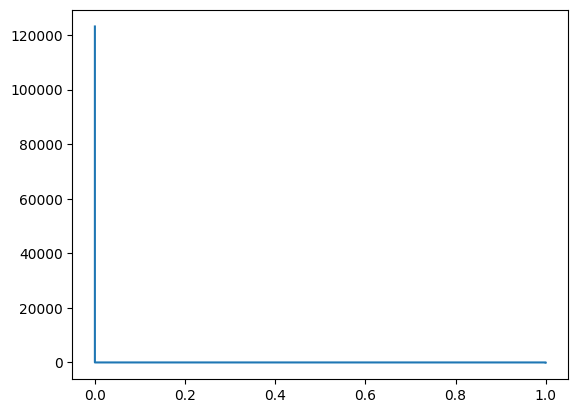

In [53]:
%matplotlib inline

x = elapsed.value_counts().index
y = elapsed.value_counts().values

plt.plot(x,y)

In [20]:
data['elapsed'] = data['elapsed'].apply(lambda x: x if x < 600 and x>=0 else np.nan)
data.tail(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed
2526690,7440,A030197005,A030000197,0,2020-10-21 08:33:20,1984,1,3.0
2526691,7441,A030071001,A030000071,0,2020-06-05 06:46:41,438,1,122.0
2526692,7441,A030071002,A030000071,0,2020-06-05 06:48:43,438,1,40.0
2526693,7441,A030071003,A030000071,1,2020-06-05 06:49:23,438,1,34.0
2526694,7441,A030071004,A030000071,0,2020-06-05 06:49:57,438,1,24.0
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,NaN
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,11.0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,46.0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,73.0
2526699,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836,1,73.0


In [21]:
data['elapsed'] = data['elapsed'].fillna(method='ffill')
data.tail(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed
2526690,7440,A030197005,A030000197,0,2020-10-21 08:33:20,1984,1,3.0
2526691,7441,A030071001,A030000071,0,2020-06-05 06:46:41,438,1,122.0
2526692,7441,A030071002,A030000071,0,2020-06-05 06:48:43,438,1,40.0
2526693,7441,A030071003,A030000071,1,2020-06-05 06:49:23,438,1,34.0
2526694,7441,A030071004,A030000071,0,2020-06-05 06:49:57,438,1,24.0
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,24.0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,11.0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,46.0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,73.0
2526699,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836,1,73.0


In [76]:
day_diff = data.loc[:,['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
day_diff = day_diff['Timestamp'].apply(lambda x: x.days)
day_diff

0           0
1           0
2           0
3           0
4           0
           ..
2526695     0
2526696    76
2526697     0
2526698     0
2526699     0
Name: Timestamp, Length: 2526700, dtype: int64

In [111]:
day_diff.value_counts()

0      2275364
1        81877
2        49066
3        31990
4        25578
        ...   
223          1
261          1
264          1
286          1
296          1
Name: Timestamp, Length: 267, dtype: int64

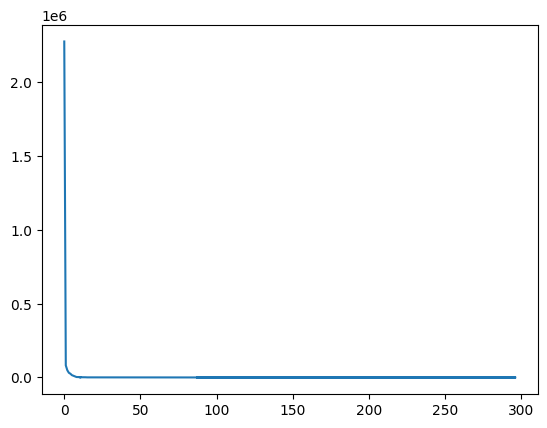

In [112]:
# Timestamp diffenrence
%matplotlib inline

x = day_diff.value_counts().index
y = day_diff.value_counts().values

plt.plot(x,y)

In [116]:
data['day_diff'] = day_diff
data['day_diff'] = data['day_diff'].apply(lambda x: x if x < 1 and x>=0 else 1)
data

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed,day_diff
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,3.0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,8.0,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,7.0,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,7.0,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,11.0,0
...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,0.0,0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,11.0,1
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,46.0,0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,73.0,0


In [117]:
data['day_diff'].value_counts()

0    2275364
1     251336
Name: day_diff, dtype: int64

#### 비율만큼 userID 선택 -> split

In [152]:
# user 선택
user_id = sorted(data['userID'].unique())
len(user_id)

7442

In [153]:
train_user = int(len(user_id)*ratio)
test_user = len(user_id) - train_user
print(f'train user : {train_user}, test user : {test_user}')

train user : 5953, test user : 1489


In [154]:
test_user_start = user_id[train_user]
test_user_index = min(data[data['userID']==test_user_start].index)

In [158]:
splited_train = data.iloc[:test_user_index]
splited_train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,11.0
...,...,...,...,...,...,...,...,...
2466719,5952,A050190004,A050000190,0,2020-10-15 08:35:54,10398,1,430891.0
2466720,5952,A050193001,A050000193,1,2020-10-20 08:17:25,10402,1,13.0
2466721,5952,A050193002,A050000193,0,2020-10-20 08:17:38,10402,1,14.0
2466722,5952,A050193003,A050000193,1,2020-10-20 08:17:52,10402,1,28.0


In [159]:
splited_test = data.iloc[test_user_index:]
splited_test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed
2466724,5953,A070084001,A070000084,0,2020-06-12 01:10:39,6828,1,2.0
2466725,5953,A070084002,A070000084,0,2020-06-12 01:10:41,6828,1,1.0
2466726,5953,A070084003,A070000084,1,2020-06-12 01:10:42,6828,1,8.0
2466727,5953,A070084004,A070000084,0,2020-06-12 01:10:50,6828,1,2.0
2466728,5953,A070084005,A070000084,0,2020-06-12 01:10:52,6828,1,2.0
...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,6632178.0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,11.0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,46.0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,73.0


In [160]:
len(splited_train), len(splited_test)

(2466724, 59976)

In [164]:
len(splited_train)/len(data), len(splited_test)/len(data)

(0.9762631099853564, 0.023736890014643606)

### 대분류 추가

In [29]:
data['bigCate'] = data['testId'].str[2]
data

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed,bigCate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0.0,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,3.0,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,8.0,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,7.0,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,7.0,6
...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,24.0,3
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,0.0,4
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,11.0,4
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,46.0,4


### 각 유저의 대분류별 정답률의 평균

In [30]:
user_bigCate_acc = data.groupby(['userID', 'bigCate']).apply(lambda x:x['answerCode'].mean())
user_bigCate_acc

userID  bigCate
0       2          0.722222
        6          0.791908
        8          0.468320
1       4          0.822719
        9          0.903409
                     ...   
7439    4          0.625000
7440    3          0.400000
        5          0.400000
7441    3          0.200000
        4          1.000000
Length: 19739, dtype: float64

In [31]:
user_bigCate_acc[0].index, user_bigCate_acc[0].values

(Index(['2', '6', '8'], dtype='object', name='bigCate'),
 array([0.72222222, 0.79190751, 0.46831956]))

In [32]:
data['user_bigCate_acc'] = 0

In [33]:
for id in tqdm.tqdm(user_id):
    d = data[data['userID']==id]
    cate_unique = d['bigCate'].unique()
    for cate in cate_unique:
        acc_mean = d[d['bigCate']==cate]['answerCode'].mean()
        data.loc[d[d['bigCate']==cate].index, 'user_bigCate_acc']=acc_mean

100%|██████████| 7442/7442 [01:15<00:00, 98.46it/s] 


In [34]:
data.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed,bigCate,user_bigCate_acc
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0.0,6,0.791908
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,3.0,6,0.791908
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,8.0,6,0.791908
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,7.0,6,0.791908
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,7.0,6,0.791908


### 각 유저의 대분류별 푼 횟수

In [35]:
user_bigCate_count = data.groupby(['userID', 'bigCate']).apply(lambda x:x['answerCode'].count())
user_bigCate_count

userID  bigCate
0       2           36
        6          346
        8          363
1       4          581
        9          352
                  ... 
7439    4           16
7440    3           10
        5            5
7441    3            5
        4            4
Length: 19739, dtype: int64

In [36]:
data['user_bigCate_count'] = 0

In [37]:
for id in tqdm.tqdm(user_id):
    d = data[data['userID']==id]
    cate_unique = d['bigCate'].unique()
    for cate in cate_unique:
        count = d[d['bigCate']==cate]['answerCode'].count()
        data.loc[d[d['bigCate']==cate].index, 'user_bigCate_count']=count

100%|██████████| 7442/7442 [01:14<00:00, 99.55it/s] 


In [38]:
data.tail(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed,bigCate,user_bigCate_acc,user_bigCate_count
2526690,7440,A030197005,A030000197,0,2020-10-21 08:33:20,1984,1,3.0,3,0.4,10
2526691,7441,A030071001,A030000071,0,2020-06-05 06:46:41,438,1,0.0,3,0.2,5
2526692,7441,A030071002,A030000071,0,2020-06-05 06:48:43,438,1,122.0,3,0.2,5
2526693,7441,A030071003,A030000071,1,2020-06-05 06:49:23,438,1,40.0,3,0.2,5
2526694,7441,A030071004,A030000071,0,2020-06-05 06:49:57,438,1,34.0,3,0.2,5
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,24.0,3,0.2,5
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,0.0,4,1.0,4
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,11.0,4,1.0,4
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,46.0,4,1.0,4
2526699,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836,1,73.0,4,1.0,4


### 각 유저의 대분류별 푼 평균 소요시간

In [39]:
user_bigCate_elapsedTime = data.groupby(['userID', 'bigCate']).apply(lambda x:x['elapsed'].mean())
user_bigCate_elapsedTime

userID  bigCate
0       2          29.972222
        6          31.254335
        8          32.148760
1       4          71.934596
        9          85.409091
                     ...    
7439    4          33.187500
7440    3          23.300000
        5          18.600000
7441    3          44.000000
        4          32.500000
Length: 19739, dtype: float64

In [40]:
data['user_bigCate_elapsedTime'] = 0

In [41]:
for id in tqdm.tqdm(user_id):
    d = data[data['userID']==id]
    cate_unique = d['bigCate'].unique()
    for cate in cate_unique:
        time = d[d['bigCate']==cate]['elapsed'].mean()
        data.loc[d[d['bigCate']==cate].index, 'user_bigCate_elapsedTime']=time

100%|██████████| 7442/7442 [01:15<00:00, 98.21it/s] 


## User 각각의 KnowledgeTag별 mean, cumsum, std

### User-Knowledge의 정답률 평균

In [50]:
kl_id = list(data['KnowledgeTag'].unique())

In [51]:
user_KT_acc = data.groupby(['userID', 'KnowledgeTag']).apply(lambda x:x['answerCode'].mean())
user_KT_acc

userID  KnowledgeTag
0       23              0.000000
        25              0.000000
        26              0.428571
        30              0.333333
        31              1.000000
                          ...   
7440    7691            0.500000
        10313           0.000000
        10328           0.000000
7441    438             0.200000
        8836            1.000000
Length: 492354, dtype: float64

In [52]:
data['user_KT_acc'] = 0

for id in tqdm.tqdm(kl_id):
    d = data[data['KnowledgeTag']==id]
    KT = d['KnowledgeTag'].unique()
    for kt in KT:
        acc_mean = d[d['KnowledgeTag']==kt]['answerCode'].mean()
        data.loc[d[d['KnowledgeTag']==kt].index, 'user_KT_acc']=acc_mean

100%|██████████| 912/912 [00:06<00:00, 150.46it/s]


In [58]:
data

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,grade,elapsed,bigCate,user_bigCate_acc,user_bigCate_count,user_bigCate_elapsedTime,user_KT_acc
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0.0,6,0.791908,346,31.254335,0.957333
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,3.0,6,0.791908,346,31.254335,0.917067
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,8.0,6,0.791908,346,31.254335,0.917067
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,7.0,6,0.791908,346,31.254335,0.917067
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,7.0,6,0.791908,346,31.254335,0.917067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1,24.0,3,0.200000,5,44.000000,0.694889
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,0.0,4,1.000000,4,32.500000,0.698551
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,11.0,4,1.000000,4,32.500000,0.698551
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,46.0,4,1.000000,4,32.500000,0.698551


In [57]:
user_KT_cumsum = data.groupby(['userID', 'KnowledgeTag', 'Timestamp']).apply(lambda x:x['answerCode'].values)
user_KT_cumsum

KeyboardInterrupt: 

In [ ]:
data['user_KT_acc'] = 0

for id in tqdm.tqdm(kl_id):
    d = data[data['KnowledgeTag']==id]
    KT = d['KnowledgeTag'].unique()
    for kt in KT:
        cum_sum = d[(d['KnowledgeTag']==kt)]['answerCode'].sort_values('Timestamp').sumsum()
        data.loc[d[d['KnowledgeTag']==kt].index, 'user_KT_cumsum']=cum_sum

In [43]:
# total data 저장
data.to_csv(data_path + 'total_data.csv', index=False)